# Draft MEP for layout manager

 - Author: Jody Klymak 
 - Github: https://github.com/jklymak/mplconstrainedlayout

## Rationale

Laying out elements in a figure (or inside a given axes) is difficult. Even just the basic case of putting one axes in a figure is complicated by the size of the labels and ticks. For instance in this case the labels don't fit on the figure:


In [3]:
# imports
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import matplotlib.gridspec as gridspec

def plot_children(fig, box, level=0, printit=True):
    '''
    Simple plotting to show where boxes are
    '''
    import matplotlib
    if isinstance(fig, matplotlib.figure.Figure):
        ax = fig.add_axes([0., 0., 1., 1.])
    else:
        ax = fig
    import matplotlib.patches as patches
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    if printit:
        print("Level:", level)
    for child in box.children:
        rect = child.get_rect()
        if printit:
            print(child)
        ax.add_patch(
            patches.Rectangle(
                (child.left.value(), child.bottom.value()),   # (x,y)
                child.width.value(),          # width
                child.height.value(),          # height
                fc = 'none',
                ec = colors[level]
            )
        )
        if level%2 == 0:
            ax.text(child.left.value(), child.bottom.value(), child.name,
                   size=12-level, color=colors[level])
        else:
            ax.text(child.right.value(), child.top.value(), child.name, 
                    ha='right', va='top', size=12-level, color=colors[level])
        
        plot_children(ax, child, level=level+1, printit=printit)

<IPython.core.display.Javascript object>


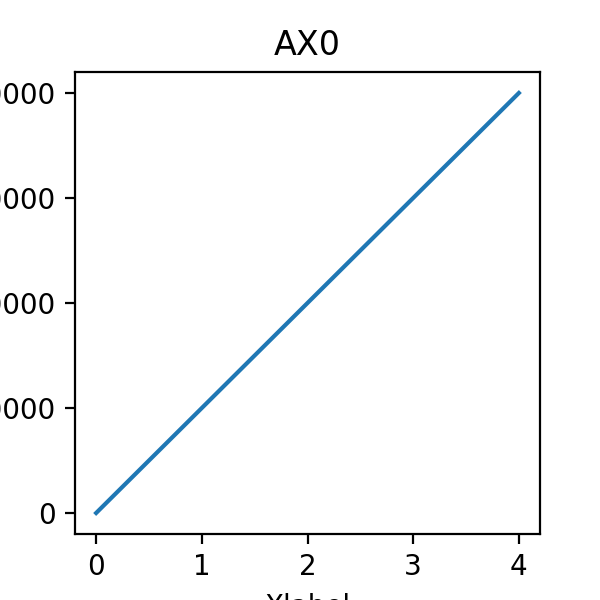

In [4]:
fig, ax = plt.subplots(figsize=(3,3), tight_layout=False)
ax.plot(np.arange(0,50000,10000))
ax.set_ylabel("Ylabel"); ax.set_xlabel("Xlabel"); ax.set_title('AX0')
# fig.tight_layout()

Calling `fig.tight_layout()` (or specifying `tight_layout=True` as an argument to `plt.subplots`) produces a perfectly acceptable result. It does this by changing the subplot parameters to make the text fit based on the difference between the axes bounding box (`ax.get_bbox_tight(renderer)`) and the size of the figure.  

However things become more complicated if we have two nested gridspecs, or if we have a colorbar that is supposed to represent more than one axes (i.e. one colorbar for four subplots).  In these cases `tight_layout` fails to properly cordon off the appropriate rectangle and just operate inside that rectangle. i.e.


<IPython.core.display.Javascript object>


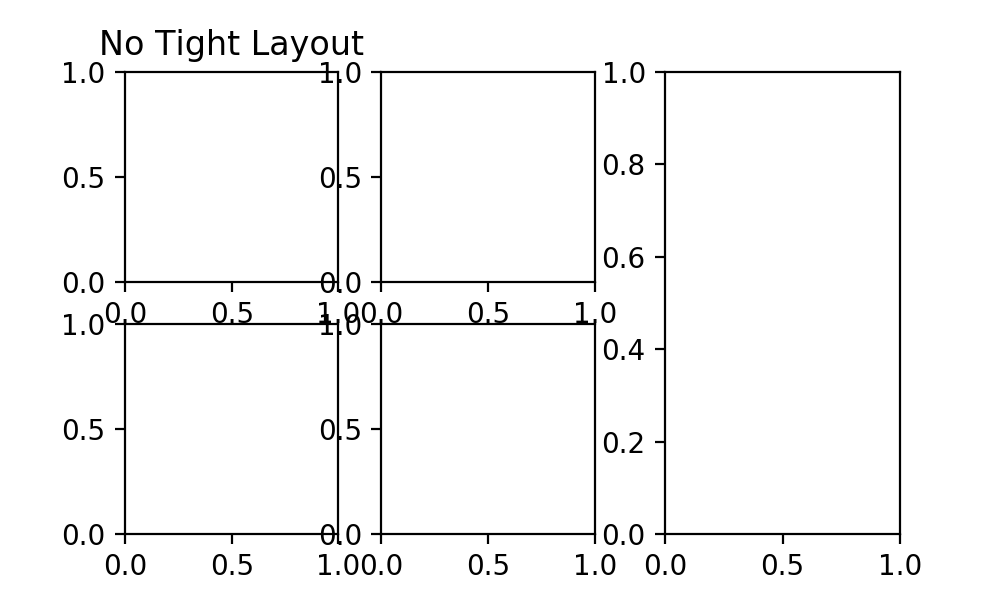

In [5]:
fig = plt.figure(figsize=(5, 3))
gstop = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
gsleft = gridspec.GridSpecFromSubplotSpec(2, 2, gstop[0])
gsright = gridspec.GridSpecFromSubplotSpec(1, 1, gstop[1])
axsleft = []
for i in range(2):
    for j in range(2):
        axsleft += [fig.add_subplot(gsleft[i,j])]
axsleft[0].set_title('No Tight Layout')
axright = fig.add_subplot(gsright[0])  

<IPython.core.display.Javascript object>


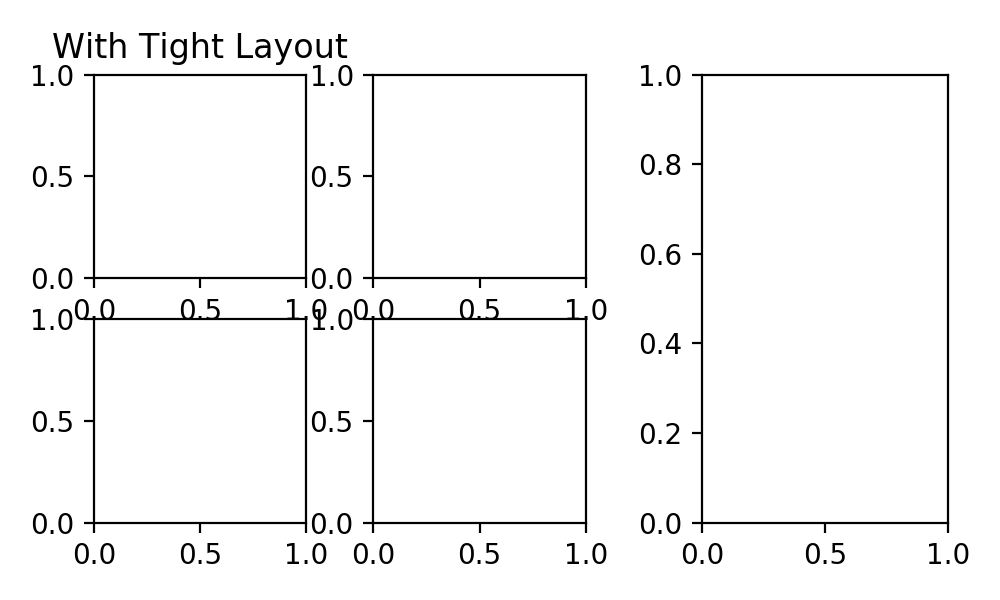

In [6]:
fig = plt.figure(figsize=(5, 3))
gstop = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
gsleft = gridspec.GridSpecFromSubplotSpec(2, 2, gstop[0])
gsright = gridspec.GridSpecFromSubplotSpec(1, 1, gstop[1])
axsleft = []
for i in range(2):
    for j in range(2):
        axsleft += [fig.add_subplot(gsleft[i,j])]
axsleft[0].set_title('With Tight Layout')


axright = fig.add_subplot(gsright[0])
fig.tight_layout()

So, `tight_layout` tries, but fails to handle this case very well.

What `tight_layout` does do nicely now, and that we will attempt to retain here, is make all the subplots inside a `gridspec` have the same margin sizes.  However, even this fails in the case where one of the axes in a gridspec has a colorbar and the other ones do not.  In that case, the layout is nicely adjusted, but the axes with the colorbar child is significantly smaller.  

More importantly, there is not currently a way to have that right-hand gridspec be some fixed width (as opposed to a fractional width) and have the rest of plot expand to take up the white-space.  This would be useful in the case of a colorbar or legend, which won't really change total size if the figure is made larger, but will certainly change fractional size.

 

## Scope

This MEP is not going to handle every aspect of layout in Matplotlib (however, the underlying proposed class `LayoutBox` could be put to work doing this).  We will instead focus on the problem of laying out axes in a figure, including dependent axes like colorbars and legends.   Inside the axes, including the labels, ticklables, and titles is not dealt with here.  

The goal is to provide a similar structure to `tight_layout()` that can be called when `figure.draw()` is called to arrange the elements of the figure, or called explicitly by the author.  


## Strategy

The strategy is to use a new package `LayoutBox` to construct the elements of the layout.  Instances of `LayoutBox` will represent axes or their external dependents, and conditions on the relationship between the boxes will be set, and then [kiwisolver](https://github.com/nucleic/kiwi) will be used to resolve the conditions.  The position of the elemnets will then be adjusted using the specifications of this layout. 

An example of the code for the layout would be

In [7]:
import LayoutBox as lb

figlb = lb.LayoutBox(parent=None, name='figlb')
figlb.set_geometry(0., 0., 1., 1.)

# make two boxes that will be laid out side by side
# they are constrained to be inside the parent.
leftlb = lb.LayoutBox(parent=figlb, name='leftlb')
rightlb = lb.LayoutBox(parent=figlb, name='rightlb')
# set their relation to one another
lb.hstack([leftlb, rightlb])
# set the right-side box width:
rightlb.set_width(0.25)

# this calls the solver
figlb.update_variables()

print(leftlb)
print(rightlb)

LayoutBox: leftlb, (left: 0.00) (bot: 0.00) (right: 0.75) (top: 1.00) (pref_width: 100000.00) (artist: None) (spine?: False)
LayoutBox: rightlb, (left: 0.75) (bot: 0.00) (right: 1.00) (top: 1.00) (pref_width: 100000.00) (artist: None) (spine?: False)


This example obviusly wouldn't have called for a solver, but using nesting much more complicated layouts can be accomplished.

### LayoutBox quick description

The `LayoutBox` is a relatively simple class.  It has variables for the location of the corners of the box (`left`, `right`, `bottom`, and `right`), and then derived dimensions like `width`,  `height`, `v_center`, and `h_center`.  

The proposal is to have a new `figure` method `figure.constrained_layout()` that will supersede `figure.tight_layout()`.  The layout will be determined by this function when called by the user or when `figure.draw()` is called. The axes and their "dependents" will be assigned instances of class `LayoutBox`, and their relationships with one another defined.

So far, I believe the API for this can be the same as the existing API for creating axes layouts, i.e. using `gridspec.GridSpec` and `gridspec.SubplotSpec` to create the virtual layout, and then using that layout to solve the constraints on the layout to produce a figure that has well-placed axes.

##  User-facing API changes

The goal with this MEP is that the user facing-API changes very little.  Layout would still be implimented using the `gridspec` package, and indeed `gridspec.GridSpec` objects will act as the top-level units for a layout. 

### gridspec:

`gridspec` (and `fig.subplots()`) is probably the easiset way to layout multiple axes.  If a user hard-codes `fig.add_axes(rect=[left, bottom, right, top])` then this is probably not an axis that needs to participate in an automatic layout. 

A `gridspec.GridSpec` instance is used to make `SubplotSpec` objects that will contain the axes (or other gridspecs for nested layouts). By default, it is propsed that all main `axes` spines in a `gridspec` will have the *same* margins with respect to the edges of the subplot. So, for instance in the layout below, the yellow boxes represent the `SubplotSpec` boundaries, and the green boxes represent where the spines of the axis will be placed.   

```python
gs = gridspec.GridSpec(2,2)
gslb = lb.LayoutBox(parent=figlb, name='gslb')

axl  = fig.add_subplot(gs[:,0])
axrt = fig.add_subplot(gs[0,1])
axrb = fig.add_subplot(gs[1,1]); 
```

<IPython.core.display.Javascript object>


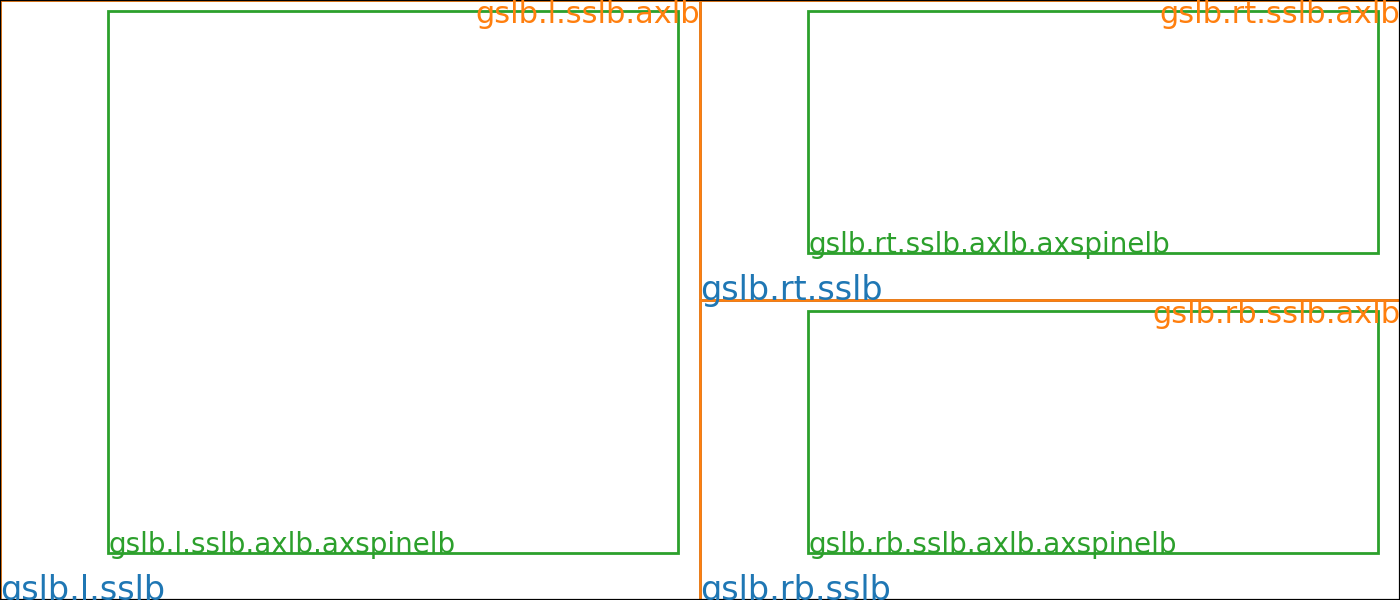

In [8]:
fig = plt.figure(figsize=(7,3))
# figure would have the below in it:
figlb = lb.LayoutBox(parent = None, name='figlb')
figlb.set_geometry(0., 0. ,1., 1.)

gs = gridspec.GridSpec(2,2)
# this would be called w/in GridSpec.  Note that it is not needed because 
# `gs` occupies all of fig, but that is not generally the case
gslb = lb.LayoutBox(parent=figlb, name='gslb')

axl = fig.add_subplot(gs[:,0])
axlsslb, axllb, axlspinelb = gslb.layout_axis_subplotspec(gs[:,0], ax=axl, name='l')
axl.set_visible(False)

axrt = fig.add_subplot(gs[0,1])
axrtsslb, axrtlb, axrtspinelb = gslb.layout_axis_subplotspec(gs[0,1], ax=axrt, name='rt')
axrt.set_visible(False)


axrb = fig.add_subplot(gs[1,1]); 
axrb.plot(np.arange(50000))
axrbsslb, axrblb, axrbspinelb = gslb.layout_axis_subplotspec(gs[1,1], ax=axrb, name='rb')
axrb.set_visible(False)

# here we make the margins match.
lb.match_margins([axlspinelb, axrtspinelb, axrbspinelb])
figlb.update_variables()
plot_children(fig, gslb, printit=False)


### colorbar: 

It is envisioned that `figure.colorbar()` will accept either a single `axes` object (as it does currently), *or* an instance of `gridspec`.  Passing an `axes` will put a new layout box to the right of the layout box that belongs to the `axes`.  

Note how the tow axes to the right also created more room on their right hand side so they have the same margin as the new axis that has a colorbar.  If this behaviour isn't desirable, the user can divide the two sides into two gridspecs.  It would perhaps be a user-callable option.  However, the presumption is that if axes are in the same gridspec, then the user wants them to have the same sized margins.  

<IPython.core.display.Javascript object>


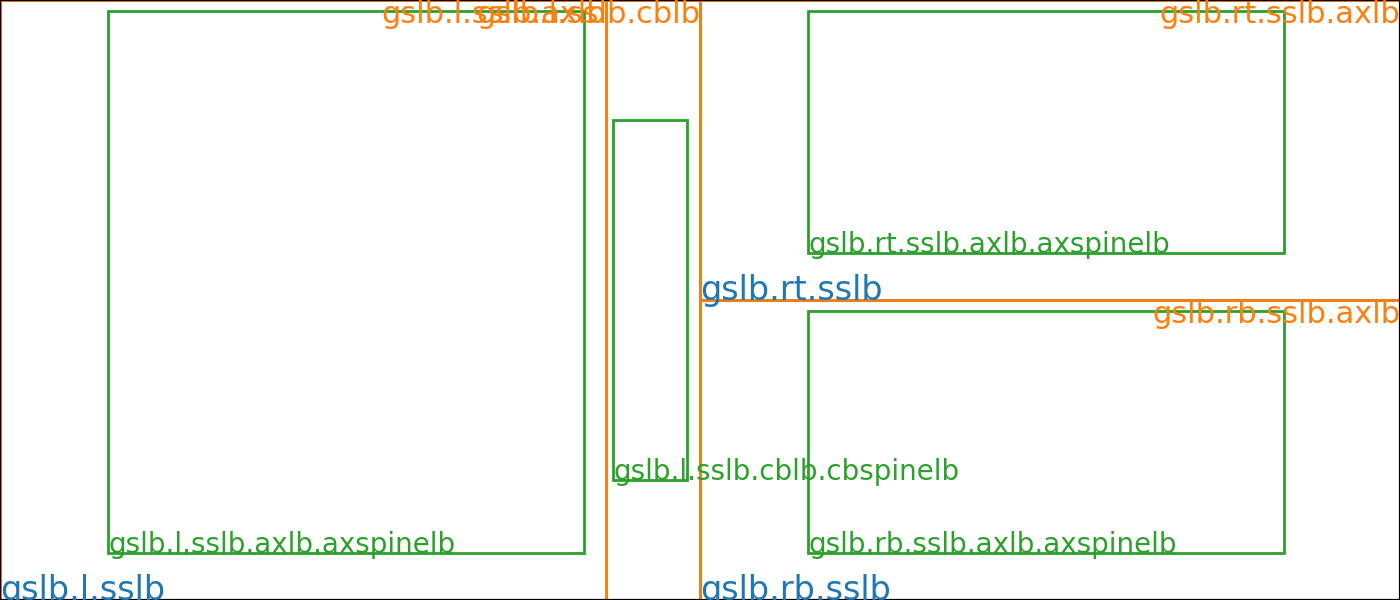

In [9]:
fig = plt.figure(figsize=(7,3))
# figure would have the below in it:
figlb = lb.LayoutBox(parent = None, name='figlb')
figlb.set_geometry(0., 0. ,1., 1.)

gs = gridspec.GridSpec(2,2)
# this would be called w/in GridSpec.  Note that it is not needed because 
# `gs` occupies all of fig, but that is not generally the case
gslb = lb.LayoutBox(parent=figlb, name='gslb')

axl = fig.add_subplot(gs[:,0])
axlsslb, axllb, axlspinelb = gslb.layout_axis_subplotspec(gs[:,0], ax=axl, name='l')
pcm=axl.pcolormesh(np.random.rand(32,32))
cbar = fig.colorbar(pcm, ax=axl)

# lets put a colorbar to the right of this one

cblb, clbspine = axllb.layout_axis_right(cbar.ax)

axl.set_visible(False)
cbar.ax.set_visible(False)


axrt = fig.add_subplot(gs[0,1])
axrtsslb, axrtlb, axrtspinelb = gslb.layout_axis_subplotspec(gs[0,1], ax=axrt, name='rt')
axrt.set_visible(False)


axrb = fig.add_subplot(gs[1,1]); 
axrb.plot(np.arange(50000))
axrbsslb, axrblb, axrbspinelb = gslb.layout_axis_subplotspec(gs[1,1], ax=axrb, name='rb')
axrb.set_visible(False)

# here we make the margins match.  We want to go two levels up because we want the 
# spines to match the subplotspec edges, *not* the parent axes...
lb.match_margins([axlspinelb, axrtspinelb, axrbspinelb], levels=2)
figlb.update_variables()
plot_children(fig, gslb, printit=False)

Passing a `gridspec` will put the colorbar to the right of all the axes in the `gridspec`, and make them all correspondingly a bit smaller.  In the example below the orange block on the right is the spine area for the colorbar (its labels would go to the right).

<IPython.core.display.Javascript object>


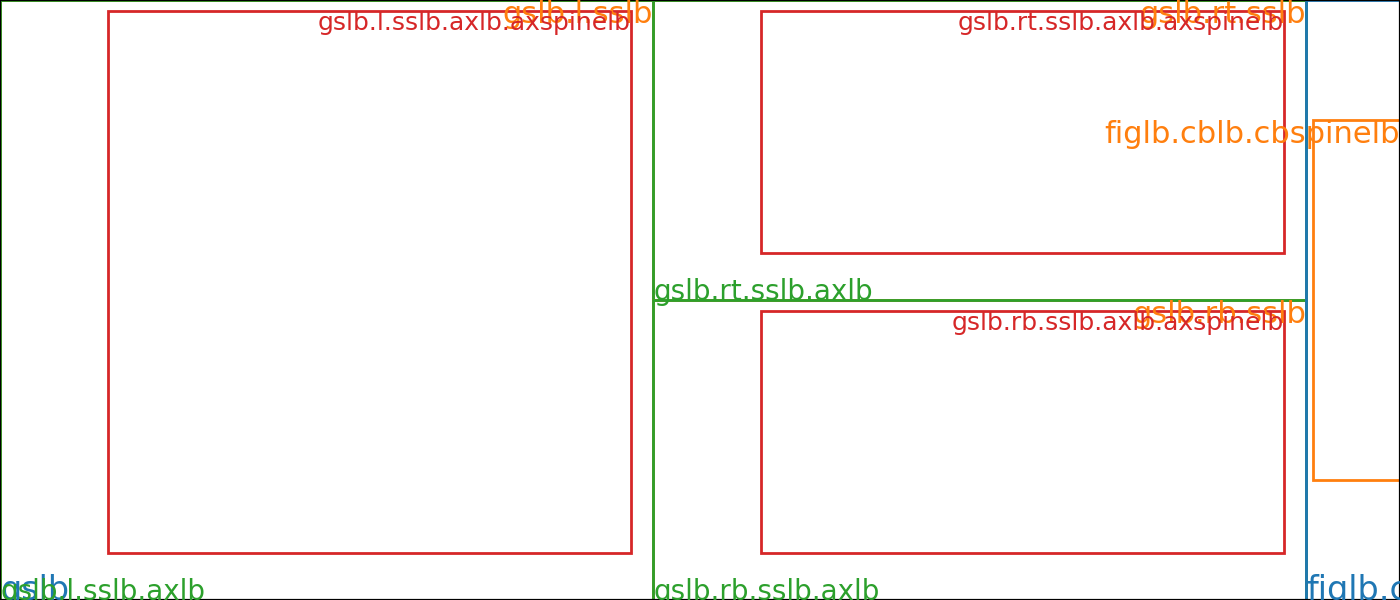

In [10]:
fig = plt.figure(figsize=(7,3))
# figure would have the below in it:
figlb = lb.LayoutBox(parent = None, name='figlb')
figlb.set_geometry(0., 0. ,1., 1.)

gs = gridspec.GridSpec(2,2)
# this would be called w/in GridSpec.  Note that it is not needed because 
# `gs` occupies all of fig, but that is not generally the case
gslb = lb.LayoutBox(parent=figlb, name='gslb')

axl = fig.add_subplot(gs[:,0])
axlsslb, axllb, axlspinelb = gslb.layout_axis_subplotspec(gs[:,0], ax=axl, name='l')
pcm=axl.pcolormesh(np.random.rand(32,32))

# lets put a colorbar to the right of this one




axrt = fig.add_subplot(gs[0,1])
axrtsslb, axrtlb, axrtspinelb = gslb.layout_axis_subplotspec(gs[0,1], ax=axrt, name='rt')
axrt.set_visible(False)


axrb = fig.add_subplot(gs[1,1]); 
axrb.plot(np.arange(50000))
axrbsslb, axrblb, axrbspinelb = gslb.layout_axis_subplotspec(gs[1,1], ax=axrb, name='rb')
axrb.set_visible(False)

cbar = fig.colorbar(pcm, ax=[axl, axrt, axrb])

cblb, clbspine = gslb.layout_axis_right(cbar.ax)



# here we make the margins match.
lb.match_margins([axlspinelb, axrtspinelb, axrbspinelb])


figlb.update_variables()
plot_children(fig, figlb, printit=False)

### legend

Todo!  I don't put legends outside of axes very often, so I haven't looked into this yet, but encasing a legend in a `LayoutBox` and doing the same thing as with a `colorbar` should not conceptually be difficult.

## Internal changes

The internal changes propsed are relatively modest

 - `figure`:
     - new attribute: `layoutbox` of type `LayoutBox`
     - in `__init__` instantiate `layoutbox`.
 
 - `gridspec.GridSpec`:
   - new attribute: `layoutbox` of type `LayoutBox`
   - new *mandatory* argument: `figure`, because the `GridSpec` needs a parent layout box.  (Q, should this be a new `gridspec` class?  
     - in `__init__` instantiate `layoutbox` based on `gridspec.rect`
 
 - `gridspec.SubplotSpec`:
     - new attribute: `layoutbox` of type `LayoutBox`
     - in `__init__` instantiate `layoutbox` using the subplotspec. 
     
     
 - `axes`:
     - new attribute: `layoutbox` of type `LayoutBox`
     - new attribute: `spinelayoutbox` of type `LayoutBox`: the layout for the spine of the axes.
     - in `__init__` instantiate both layout boxes.  
     - in `figure.draw` we need to call a `constrained_layout` to calculate and place the axes in the right positions.
 
 - `figure.colorbar`: 
     - constrain the initialized axis (as above) to be to the right of the main axes or the `gridspec` that it will take space from.
     
 - `axes.legend` and `figure.legend`: 
     - TODO, but likely similar.
     
###  Comment on strategy:

It *should* be possible to simply impliment the constrained layout like `tight_layout` does without any changes to the main classes.  However, I don't think `tight_layout` handles nested gridspecs beyond two levels, and life is simpler if the `LayoutBox` is a property of the artist or layout element rather than a parallel structure.  
 